# Comparer distance Courte /  distance pollen


### Joindre la colonne de pollen au fichier avec les itinéraires aléatoires 

In [26]:
import sys
sys.path.append("../")
sys.path.append("../../../script_python")
from data_utils import *
from function_utils import *

sys.path.append("../../../")
from global_variable import *
import os
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import scipy.stats as stats

#from notebook.data_loading.network_loading import load_network_from_gpkg
#from notebook.data_loading.itineraires_loading import load_itineraires_from_csv 

# Charger les données 
#edges, nodes = load_network_from_gpkg(final_network_pollen_path)

gpkg_path = globpath("./score_calculation_it/output_data/network/graph/final_network_pollen.gpkg")
edges = gpd.read_file(gpkg_path, layer="edges")
nodes = gpd.read_file(gpkg_path, layer="nodes")

# Vérifier que les colonnes nécessaires existent
required_columns = {"u", "v", "score_distance_pollen", "length", "oneway"}
missing_columns = required_columns - set(edges.columns)
if missing_columns:
    raise ValueError(f"Les colonnes suivantes sont manquantes dans le fichier edges : {missing_columns}")

# Charger le fichier CSV contenant les itinéraires optimisés en distance
#itineraires = load_itineraires_from_csv(itineraire)
itinéraire = globpath("./score_calculation_it/notebook/generation_it/itinéraire_court.csv")
itinéraire_court_pollen = pd.read_csv(itinéraire)

# Construction du graph
G_pollen = nx.DiGraph()
for _, row in edges.iterrows():
    G_pollen.add_edge(row['u'], row['v'], weight=row['score_distance_pollen'], length=row['length'])
    if not row['oneway']:
        G_pollen.add_edge(row['v'], row['u'], weight=row['score_distance_pollen'], length=row['length'])

# Vérifier que tous les start_nodes et end_nodes sont bien dans G_pollen
nodes_in_graph = set(G_pollen.nodes)
itinéraire_court_pollen = itinéraire_court_pollen[itinéraire_court_pollen["start_node"].isin(nodes_in_graph) & itinéraire_court_pollen["end_node"].isin(nodes_in_graph)]

# Calcul itinéraire minimisant le score_distance_pollen (sans stocker le chemin)
def compute_least_pollen_score(start, end):
    """
    Calcule la somme du score_distance_pollen et la distance totale du chemin minimisant le pollen entre deux nœuds.
    """
    try:
        path = nx.shortest_path(G_pollen, source=start, target=end, weight="weight")
        pollen_score = sum(G_pollen[path[i]][path[i+1]]["weight"] for i in range(len(path)-1))
        total_distance = sum(G_pollen[path[i]][path[i+1]]["length"] for i in range(len(path)-1))
        return pollen_score, total_distance  # Retourne uniquement le score de pollen et la distance
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return np.nan, np.nan  # Aucun chemin trouvé

# Exécuter en parallèle
with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(lambda row: compute_least_pollen_score(getattr(row, "start_node"), getattr(row, "end_node")), itinéraire_court_pollen.itertuples(index=False)))

# Ajouter les résultats au DataFrame
itinéraire_court_pollen["pollen_score"], itinéraire_court_pollen["distance_pollen"] = zip(*results)

# Calcul de pollen_court
def compute_pollen_court(start, end):
    try:
        path = nx.shortest_path(G_pollen, source=start, target=end, weight="length")
        pollen_court = sum(G_pollen[path[i]][path[i+1]]["weight"] for i in range(len(path)-1))
        return pollen_court
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return np.nan

# Exécuter en parallèle pour pollen_court
with ThreadPoolExecutor(max_workers=4) as executor:
    pollen_court_results = list(executor.map(lambda row: compute_pollen_court(getattr(row, "start_node"), getattr(row, "end_node")), itinéraire_court_pollen.itertuples(index=False)))

itinéraire_court_pollen["pollen_court"] = pollen_court_results

# Supprimer les itinéraires où aucun chemin n'a été trouvé
itinéraire_court_pollen = itinéraire_court_pollen.dropna(subset=["pollen_score", "distance_pollen", "pollen_court"])

# Sauvegarde et visualisation
itinéraire_court_pollen.to_csv("itinéraire_court_pollen.csv", index=False)

print(f"\n Calcul terminé : {len(itinéraire_court_pollen)} itinéraires enregistrés dans 'itinéraire_court_pollen.csv' !")



 Calcul terminé : 1082 itinéraires enregistrés dans 'itinéraire_court_pollen.csv' !


In [27]:
itinéraire_court_pollen

,start_node,end_node,distance_court,pollen_score,distance_pollen,pollen_court
0,3380751025,5657136849,2742.877,2777.795,2777.795,3178.363
1,11356942377,171760149,1910.433,1909.474,1909.474,1909.474
2,2225197158,4463347218,3511.353,3511.353,3511.353,3511.353
3,7603662257,8913559675,875.318,5120.399,898.929,5251.908
4,6915264516,373344984,1826.830,3406.042,2127.097,7647.190
...,...,...,...,...,...,...
1081,1474023346,2109760437,2821.256,2821.256,2821.256,2821.256
1082,1357967486,591898696,3091.884,5344.694,3433.726,7940.297
1084,976140519,7356888324,1362.956,1362.956,1362.956,1362.956
1085,11197666281,2838044698,3505.793,3834.972,3834.972,4289.823


In [28]:
print_statistics(itinéraire_court_pollen, ["distance_court", "distance_pollen"])


Statistiques Descriptives:
       distance_court  distance_pollen
count     1082.000000      1082.000000
mean      2273.035513      2497.577378
std        998.116068      1179.849169
min        600.642000       600.642000
25%       1392.598750      1506.239250
50%       2260.035500      2448.983500
75%       3150.756250      3413.393250
max       3999.758000      7257.725000


# Visualisation 

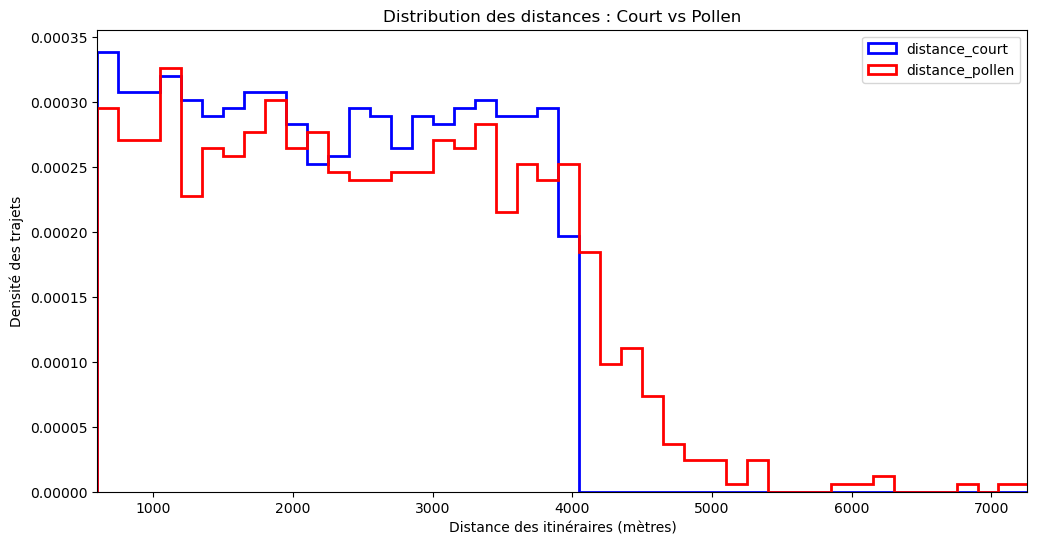

In [29]:
plot_histogram(itinéraire_court_pollen, 
               col_x="distance_court", 
               col_y="distance_pollen", 
               xlabel="Distance des itinéraires (mètres)", 
               ylabel="Densité des trajets", 
               title="Distribution des distances : Court vs Pollen")

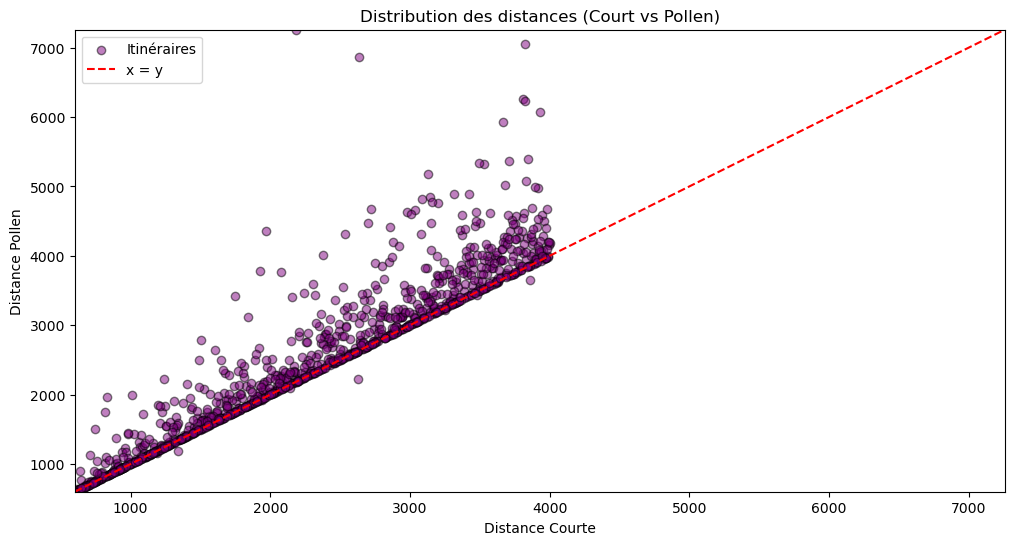

In [30]:
plot_scatter(itinéraire_court_pollen, "distance_court", "distance_pollen", 
         label_x="Distance Courte", label_y="Distance Pollen", 
         title="Distribution des distances (Court vs Pollen)")

#### Test global 

In [31]:
# Vérifier si `distance_pollen` est globalement plus grande que `distance_court`
moyenne_distance_court = itinéraire_court_pollen["distance_court"].mean()
moyenne_distance_pollen = itinéraire_court_pollen["distance_pollen"].mean()

# Affichage des résultats globaux
global_results_pollen = pd.DataFrame({
    "Moyenne Distance Court": [moyenne_distance_court],
    "Moyenne Distance Pollen": [moyenne_distance_pollen],
    "Différence Absolue": [moyenne_distance_pollen - moyenne_distance_court],
    "Différence Relative (%)": [(moyenne_distance_pollen - moyenne_distance_court) / moyenne_distance_court * 100]
})

print("\n COMPARAISON DES DISTANCES ")
print(global_results_pollen)


 COMPARAISON DES DISTANCES 
   Moyenne Distance Court  Moyenne Distance Pollen  Différence Absolue  \
0             2273.035513              2497.577378          224.541865   

   Différence Relative (%)  
0                 9.878502  


#### Découpage des données par pas 

In [32]:
# Définition du pas de 148m
step_size = 300

# Définition des bornes min/max avec une marge pour inclure toutes les valeurs
min_distance = itinéraire_court_pollen["distance_court"].min()
max_distance = itinéraire_court_pollen["distance_court"].max()

# Création des intervalles de 148m en s'assurant que max_distance est bien inclus
bins = np.arange(min_distance, max_distance + step_size, step_size)

# Création des groupes avec pd.cut() en forçant l'inclusion des bornes
itinéraire_court_pollen["distance_group"] = pd.cut(
    itinéraire_court_pollen["distance_court"], bins, include_lowest=True
)

# Vérifier la taille des groupes
group_sizes = itinéraire_court_pollen["distance_group"].value_counts().sort_index()
print("\nTAILLE DES GROUPES INITIAUX (PAS 148)")
print(group_sizes)


TAILLE DES GROUPES INITIAUX (PAS 148)
distance_group
(600.6410000000001, 900.642]    105
(900.642, 1200.642]             102
(1200.642, 1500.642]             96
(1500.642, 1800.642]             98
(1800.642, 2100.642]             96
(2100.642, 2400.642]             83
(2400.642, 2700.642]             95
(2700.642, 3000.642]             90
(3000.642, 3300.642]             94
(3300.642, 3600.642]             96
(3600.642, 3900.642]             95
(3900.642, 4200.642]             32
Name: count, dtype: int64


In [33]:
# Initialisation des résultats
results = []

# Calcul des statistiques pour chaque groupe
for group in itinéraire_court_pollen["distance_group"].unique():
    subset = itinéraire_court_pollen[itinéraire_court_pollen["distance_group"] == group]

    # Test de Wilcoxon
    stat, p_value = wilcoxon(subset["distance_pollen"], subset["distance_court"], alternative='greater')

    # Calcul du d de Cohen
    d_value = cohen_d(subset["distance_pollen"], subset["distance_court"])

    # Ajout des résultats dans la liste
    results.append({
        "Intervalle de Distance": group, 
        "Nombre d'Itinéraires": len(subset),
        "Statistique Wilcoxon": stat,
        "p-value": p_value,
        "Cohen's d": d_value
    })

# Création du DataFrame final
distance_pollen_results = pd.DataFrame(results)

# Affichage des résultats complets
distance_pollen_results
distance_pollen_results = distance_pollen_results.sort_values(by="Intervalle de Distance", ascending=True)
distance_pollen_results

,Intervalle de Distance,Nombre d'Itinéraires,Statistique Wilcoxon,p-value,Cohen's d
3,"(600.6410000000001, 900.642]",105,2174.5,1.080358e-07,0.335507
8,"(900.642, 1200.642]",102,2226.0,2.677703e-08,0.429572
9,"(1200.642, 1500.642]",96,2490.0,1.321558e-09,0.552506
5,"(1500.642, 1800.642]",98,2983.5,3.404332e-12,0.568096
1,"(1800.642, 2100.642]",96,2407.0,4.909401e-11,0.472870
10,"(2100.642, 2400.642]",83,2111.5,6.280209e-11,0.457078
7,"(2400.642, 2700.642]",95,2812.5,1.372137e-12,0.471100
0,"(2700.642, 3000.642]",90,3171.5,4.927512e-14,0.677214
4,"(3000.642, 3300.642]",94,3164.5,6.355350e-14,0.657740
2,"(3300.642, 3600.642]",96,3673.0,4.788244e-14,0.797311


- Plus la valeur de Statistique Wilcoxon est grande  plus distance_bruit est systématiquement plus grand que distance_court 

- p < seuil alpha la différence entre distance_bruit et distance_court est statistiquement significative

- d de Cohen : Taille de l'effet (Plus la valeur est grande plus la différence entre la distance des chemins courts et la distance des chemins ou on a minimisé le bruit est forte.)

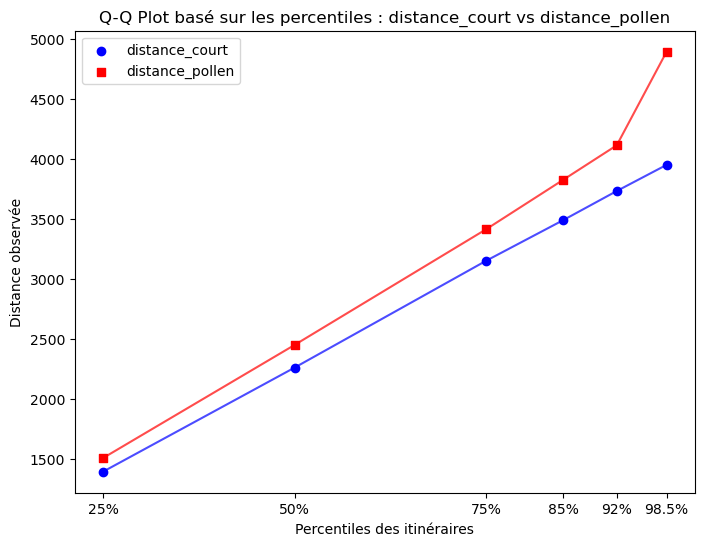

In [34]:
plot_qq(itinéraire_court_pollen, col_court="distance_court", col_score="distance_pollen")

### Questions : 
- Combien d'itinéraires > à 30% 

- Quelle est la fréquence des itinéraires > à 30%

In [35]:
# Définition des quantiles à calculer
quantiles = [0.25, 0.5, 0.75, 0.85, 0.92, 0.985]

# Liste pour stocker les résultats
resultats_list = []


# Calcul de l'augmentation relative de la distance en %
itinéraire_court_pollen["relative_distance_increase"] = (
    (itinéraire_court_pollen["distance_pollen"] - itinéraire_court_pollen["distance_court"]) / 
    itinéraire_court_pollen["distance_court"]
) * 100

# Parcours de chaque groupe d'intervalle
for intervalle in itinéraire_court_pollen["distance_group"].cat.categories:
    # Sélection des données correspondant à l'intervalle
    subset = itinéraire_court_pollen[itinéraire_court_pollen["distance_group"] == intervalle]

    

    # Calcul des quantiles pour l'augmentation relative de la distance
    quantiles_distance = subset["relative_distance_increase"].quantile(quantiles)

    # Calcul de la fréquence des itinéraires > 30% plus longs
    freq_plus_30 = (subset["relative_distance_increase"] > 30).mean() * 100

    # Nombre total de trajets dans cet intervalle
    total_trajets = len(subset)

    # Conversion du pourcentage en nombre d'itinéraires
    nombre_itineraires_sup_30 = int(freq_plus_30 / 100 * total_trajets)

    # Trouver le quantile le plus proche de 30 mais en dessous
    quantiles_below_30 = {f"Q{int(q*100)}": quantiles_distance[q] for q in quantiles if quantiles_distance[q] <= 30}
    quantile_proche_30 = max(quantiles_below_30, key=quantiles_below_30.get) if quantiles_below_30 else None

    # Création d'un dictionnaire avec les résultats
    result_dict = {
        "Intervalle": str(intervalle),  # Convertir en string pour un affichage clair
        "Q25": quantiles_distance[0.25],
        "Q50": quantiles_distance[0.5],
        "Q75": quantiles_distance[0.75],
        "Q85": quantiles_distance[0.85],
        "Q92": quantiles_distance[0.92],
        "Q98.5": quantiles_distance[0.985],
        "Quantile_≤_30": quantile_proche_30,  # Le quantile sous 30%
        "Fréquence_>_30%": freq_plus_30,
        "Nombre_itinéraires_>_30%": nombre_itineraires_sup_30  # Nombre d'itinéraires > 30%
    }

    # Ajouter le dictionnaire à la liste des résultats
    resultats_list.append(result_dict)

# Transformer les résultats en DataFrame final
df_resultats_final_pollen = pd.DataFrame(resultats_list)
df_resultats_final_pollen = df_resultats_final_pollen.round(2)
df_resultats_final_pollen

,Intervalle,Q25,Q50,Q75,Q85,Q92,Q98.5,Quantile_≤_30,Fréquence_>_30%,Nombre_itinéraires_>_30%
0,"(600.6410000000001, 900.642]",0.00,0.00,2.71,10.83,24.88,108.49,Q92,7.62,8
1,"(900.642, 1200.642]",0.00,0.00,4.36,15.52,24.56,56.73,Q92,6.86,7
2,"(1200.642, 1500.642]",0.00,0.00,12.77,24.58,38.68,61.11,Q85,11.46,10
3,"(1500.642, 1800.642]",0.00,1.95,12.04,18.89,34.43,76.09,Q85,10.20,10
4,"(1800.642, 2100.642]",0.00,1.09,10.56,16.39,29.61,89.82,Q92,8.33,7
5,"(2100.642, 2400.642]",0.00,4.16,15.29,25.72,32.54,66.36,Q85,9.64,8
6,"(2400.642, 2700.642]",0.00,2.14,14.40,20.41,27.28,57.87,Q92,4.21,4
7,"(2700.642, 3000.642]",0.00,5.73,12.55,22.97,38.42,62.02,Q85,13.33,12
8,"(3000.642, 3300.642]",0.00,3.65,13.23,16.83,41.22,55.23,Q85,9.57,9
9,"(3300.642, 3600.642]",0.00,6.12,13.71,19.61,29.41,49.33,Q92,7.29,7


In [ ]:
print(f"Nombre total d'itinéraires ayant une augmentation > 30% : {df_resultats_final_pollen["Nombre_itinéraires_>_30%"].sum()}")
print(f"Moyenne des fréquences > 30% : {df_resultats_final_pollen["Fréquence_>_30%"].mean()}")

Nombre total d'itinéraires ayant une augmentation > 30% : 91
Moyenne des fréquences > 30% : 8.3375


Interpretaion pour le premier intervalle :

- 98.5% des trajets ont une augmentation de distance ≤ 108%
- 7% des trajets dépassent 30% d'augmentation

# Comparaison des scores de pollen entre les itinéraires courts et minimisé pollen 

In [37]:
print_statistics(itinéraire_court_pollen, ["pollen_court", "pollen_score"])


Statistiques Descriptives:
       pollen_court  pollen_score
count   1082.000000   1082.000000
mean    4178.509896   3022.596066
std     3133.470683   1749.401657
min      600.642000    600.642000
25%     1852.794750   1671.213500
50%     3303.991500   2827.382500
75%     5613.902500   3903.772750
max    19244.645000  11147.382000


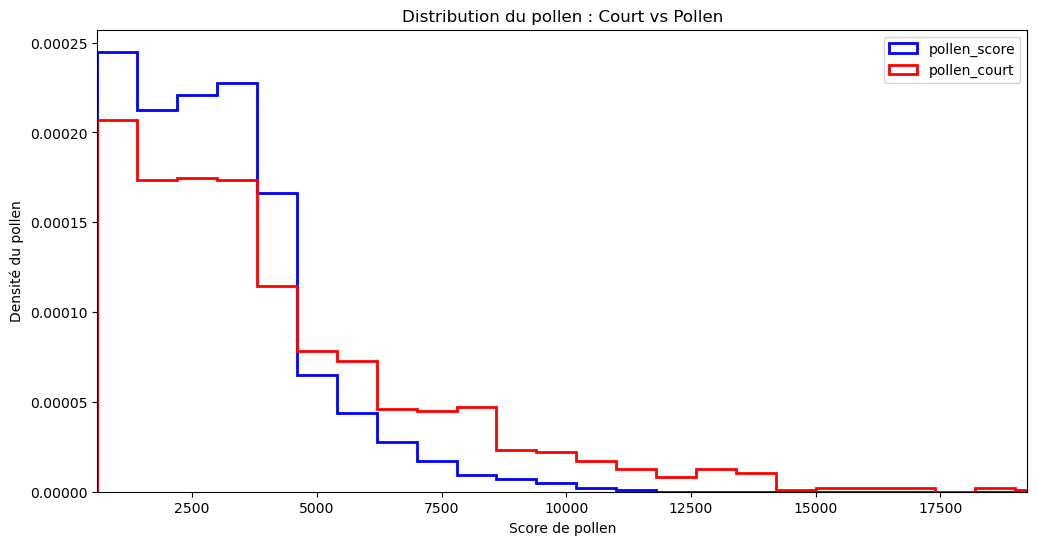

In [38]:
plot_histogram(itinéraire_court_pollen, binwidth= 800,
               col_x="pollen_score", 
               col_y="pollen_court", 
               xlabel="Score de pollen", 
               ylabel="Densité du pollen", 
               title="Distribution du pollen : Court vs Pollen")

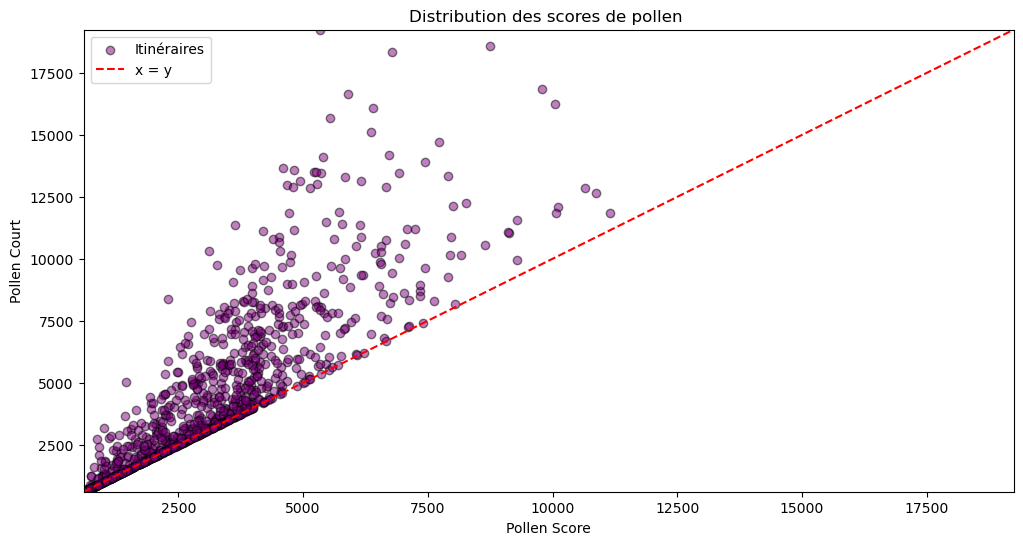

In [39]:
plot_scatter(itinéraire_court_pollen, "pollen_score", "pollen_court", 
         label_x="Pollen Score", label_y="Pollen Court", 
         title="Distribution des scores de pollen ")

In [40]:
# Vérifier si `pollen_court` est globalement plus grande que `pollen_score`
moyenne_pollen_court = itinéraire_court_pollen["pollen_court"].mean()
moyenne_pollen_score = itinéraire_court_pollen["pollen_score"].mean()

# Affichage des résultats globaux
global_results_pollen = pd.DataFrame({
    "Moyenne pollen Court": [moyenne_pollen_court],
    "Moyenne pollen Score": [moyenne_pollen_score],
    "Différence Absolue": [moyenne_pollen_court-moyenne_pollen_score],
    "Différence Relative (%)": [(moyenne_pollen_court-moyenne_pollen_score) / moyenne_pollen_court * 100]
})

print("\n COMPARAISON DU pollen")
print(global_results_pollen)


 COMPARAISON DU pollen
   Moyenne pollen Court  Moyenne pollen Score  Différence Absolue  \
0           4178.509896           3022.596066         1155.913831   

   Différence Relative (%)  
0                27.663302  


In [41]:
# Définition du pas de 148m
step_size = 300

# Définition des bornes min/max avec une marge pour inclure toutes les valeurs
min_distance = itinéraire_court_pollen["distance_court"].min()
max_distance = itinéraire_court_pollen["distance_court"].max()

# Création des intervalles de 148m en s'assurant que max_distance est bien inclus
bins = np.arange(min_distance, max_distance + step_size, step_size)

# Création des groupes avec pd.cut() en forçant l'inclusion des bornes
itinéraire_court_pollen["distance_group"] = pd.cut(
    itinéraire_court_pollen["distance_court"], bins, include_lowest=True
)

# Vérifier la taille des groupes
group_sizes = itinéraire_court_pollen["distance_group"].value_counts().sort_index()
print("\nTAILLE DES GROUPES INITIAUX (PAS 148)")
print(group_sizes)


TAILLE DES GROUPES INITIAUX (PAS 148)
distance_group
(600.6410000000001, 900.642]    105
(900.642, 1200.642]             102
(1200.642, 1500.642]             96
(1500.642, 1800.642]             98
(1800.642, 2100.642]             96
(2100.642, 2400.642]             83
(2400.642, 2700.642]             95
(2700.642, 3000.642]             90
(3000.642, 3300.642]             94
(3300.642, 3600.642]             96
(3600.642, 3900.642]             95
(3900.642, 4200.642]             32
Name: count, dtype: int64


In [42]:
# Initialisation des résultats pour Wilcoxon
results = []

# Calcul des statistiques pour chaque groupe (pollen_court vs pollen_score)
for group in itinéraire_court_pollen["distance_group"].unique():
    subset = itinéraire_court_pollen[itinéraire_court_pollen["distance_group"] == group]

    # Test de Wilcoxon pour vérifier si pollen_score est inférieur à pollen_court
    stat, p_value = wilcoxon(subset["pollen_score"], subset["pollen_court"], alternative='less')

    # Calcul du d de Cohen
    mean_diff = subset["pollen_court"].mean() - subset["pollen_score"].mean()
    pooled_std = np.sqrt((subset["pollen_court"].std() ** 2 + subset["pollen_score"].std() ** 2) / 2)
    d_value = mean_diff / pooled_std if pooled_std > 0 else np.nan  # Éviter la division par zéro

    # Ajout des résultats dans la liste
    results.append({
        "Intervalle de Distance": group,
        "Nombre d'Itinéraires": len(subset),
        "Statistique Wilcoxon": stat,
        "p-value": p_value,
        "Cohen's d": d_value
    })

# Création du DataFrame final avec les résultats
pollen_score_results = pd.DataFrame(results)
pollen_score_results = pollen_score_results.sort_values(by="Intervalle de Distance", ascending=True)
pollen_score_results

,Intervalle de Distance,Nombre d'Itinéraires,Statistique Wilcoxon,p-value,Cohen's d
3,"(600.6410000000001, 900.642]",105,0.0,3.976442e-07,0.234223
8,"(900.642, 1200.642]",102,0.0,3.869866e-08,0.318211
9,"(1200.642, 1500.642]",96,0.0,2.589627e-09,0.425407
5,"(1500.642, 1800.642]",98,0.0,2.571877e-11,0.511786
1,"(1800.642, 2100.642]",96,0.0,1.751932e-10,0.426578
10,"(2100.642, 2400.642]",83,0.0,3.778465e-10,0.631301
7,"(2400.642, 2700.642]",95,0.0,2.571877e-11,0.663496
0,"(2700.642, 3000.642]",90,0.0,8.147779e-12,0.646789
4,"(3000.642, 3300.642]",94,0.0,1.762749e-12,0.720218
2,"(3300.642, 3600.642]",96,0.0,5.598502e-13,0.814256


#### Stat Wilcoxon :
Plus la valeur est grande plus le bruit des chemins courts est supérieur à celui des chemins ou on a minimisé le bruit, donc plus l’optimisation du bruit est efficace

#### P_Value : 

Plus la valeur est faible plus la réduction du bruit est statistiquement significative (5%)

#### Cohen : 

Plus la valeur est grande plus la différence entre le bruit des chemins courts et le bruit des chemins ou on a minimisé le bruit est forte. Un grand effet indique une forte réduction du bruit.

## A partir de 1800m, commence vraiment à augmenter (Modéré -> Fort), l'effet de la distance devient plus fort au dela de 1800 m.

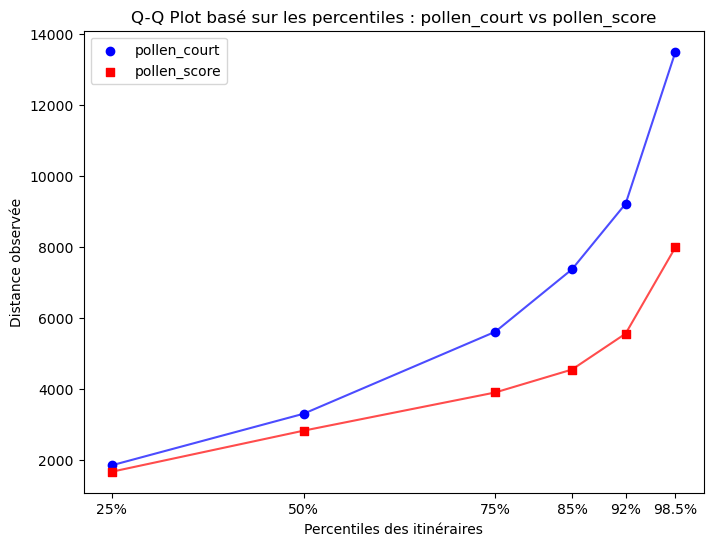

In [43]:
plot_qq(itinéraire_court_pollen, col_court="pollen_court", col_score="pollen_score")

## Mesure la réduction du pollen 

(pollen_court - pollen_score)

Question : Pour chaque intervalle quelle est la réduction moyenne du bruit en % ?

In [44]:
# Définition des quantiles à calculer
quantiles = [0.25, 0.5, 0.75, 0.85, 0.92, 0.985]

# Liste pour stocker les résultats
resultats_pollen = []

# Parcours de chaque groupe d'intervalle
for intervalle in itinéraire_court_pollen["distance_group"].cat.categories:
    # Sélection des données correspondant à l'intervalle 
    subset = itinéraire_court_pollen[itinéraire_court_pollen["distance_group"] == intervalle].copy()

    # Calcul de la réduction du pollen (absolue)
    subset.loc[:, "réduction_pollen"] = subset["pollen_court"] - subset["pollen_score"]

    # Calcul de la réduction du pollen en pourcentage
    subset.loc[:, "réduction_pollen_%"] = (subset["réduction_pollen"] / subset["pollen_court"]) * 100

    # Calcul du gain par mètre (réduction du pollen divisée par la distance de l'itinéraire court)
    subset.loc[:, "gain_par_mètre"] = subset["réduction_pollen"] / subset["distance_court"]

    # Calcul des quantiles pour la réduction du pollen et le gain par mètre
    quantiles_pollen_pct = subset["réduction_pollen_%"].quantile(quantiles)
    quantiles_gain_m = subset["gain_par_mètre"].quantile(quantiles)

    # Calcul de la moyenne de la réduction du pollen et du gain par mètre
    moyenne_réduction_pollen_pct = subset["réduction_pollen_%"].mean()
    moyenne_gain_par_mètre = subset["gain_par_mètre"].mean() # Peut etre en % ?

    # Création d'un dictionnaire avec les résultats
    result_pollen_dict = {
        "Intervalle": str(intervalle),  
        "Q25 (Pollen %)": quantiles_pollen_pct[0.25],
        "Q50 (Pollen %)": quantiles_pollen_pct[0.5],
        "Q75 (Pollen %)": quantiles_pollen_pct[0.75],
        "Q85 (Pollen %)": quantiles_pollen_pct[0.85],
        "Q92 (Pollen %)": quantiles_pollen_pct[0.92],
        "Q98.5 (Pollen %)": quantiles_pollen_pct[0.985],
        "Moyenne Réduction Pollen %": moyenne_réduction_pollen_pct,
        "Moyenne Gain par mètre": moyenne_gain_par_mètre
    }

    # Ajouter le dictionnaire à la liste des résultats
    resultats_pollen.append(result_pollen_dict)

# Transformer les résultats en DataFrame final
df_resultats_pollen = pd.DataFrame(resultats_pollen)
df_resultats_pollen = df_resultats_pollen.round(2)

df_resultats_pollen

,Intervalle,Q25 (Pollen %),Q50 (Pollen %),Q75 (Pollen %),Q85 (Pollen %),Q92 (Pollen %),Q98.5 (Pollen %),Moyenne Réduction Pollen %,Moyenne Gain par mètre
0,"(600.6410000000001, 900.642]",0.0,0.00,11.48,18.70,37.39,61.29,7.95,0.21
1,"(900.642, 1200.642]",0.0,0.00,20.10,32.17,47.70,63.69,11.39,0.31
2,"(1200.642, 1500.642]",0.0,0.00,28.83,39.35,48.09,56.64,13.84,0.35
3,"(1500.642, 1800.642]",0.0,5.75,32.66,39.50,46.53,56.75,16.17,0.43
4,"(1800.642, 2100.642]",0.0,2.75,29.06,39.95,50.72,65.70,14.79,0.42
5,"(2100.642, 2400.642]",0.0,15.66,36.01,43.05,48.87,60.50,19.86,0.51
6,"(2400.642, 2700.642]",0.0,8.24,39.54,45.33,54.20,60.82,19.30,0.49
7,"(2700.642, 3000.642]",0.0,14.03,37.00,42.26,50.47,59.06,19.57,0.48
8,"(3000.642, 3300.642]",0.0,13.12,35.56,52.64,59.08,64.30,20.70,0.59
9,"(3300.642, 3600.642]",0.0,13.99,42.08,48.32,50.98,56.86,21.18,0.50


In [49]:
print(f"Moyenne Réduction pollen > 30% : {df_resultats_pollen["Moyenne Réduction Pollen %"].mean()}")
print(f"Moyenne Gain par mètre: {df_resultats_pollen["Moyenne Gain par mètre"].mean()}")

Moyenne Réduction pollen > 30% : 17.804166666666664
Moyenne Gain par mètre: 0.4675


## En dessous de 1500m, la réduction du pollen est très faible, avec une médiane à 0%
## À partir de 1500-1800m, la réduction devient plus significative
## L'effet devient fort au-delà de 2100m, avec une moyenne de réduction dépassant 20%
## Le gain par mètre augmente fortement après 2100m et atteint un maximum à 3600-3900m
## Amélioration à partir de 1800m 

Interpretation pour la première intervalle : 

- 50% des itinéraires ont une réduction du pollen de 0% ou moins 

- 98.5% des itinéraires ont une réduction du pollen inférieure à 61.29%.
 
- En moyenne les itinéraires réduisent le pollen de 7%

- En moyenne les itinéraires on un gain de 0.21 par mètre

In [46]:
import geopandas as gpd

# Chemin du fichier GeoPackage contenant le réseau
gpkg_path = "./score_calculation_it/output_data/network/graph/final_network_pollen.gpkg"


#edges = edges.rename(columns={"geom_wkt": "geometry"})  # Adapter si nécessaire

In [47]:
from shapely.geometry import LineString
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import os

# Vérifier que la colonne "geometry" est bien présente dans edges
if "geometry" in edges.columns:
    # Créer un dictionnaire pour récupérer la géométrie des tronçons du réseau
    edge_geometry_dict = edges.set_index(["u", "v"])["geometry"].to_dict()

    # Fonction pour récupérer la géométrie complète d'un itinéraire
    def compute_geometry(start, end):
        try:
            path = nx.shortest_path(G_pollen, source=start, target=end, weight="length")
            path_lines = [edge_geometry_dict.get((path[i], path[i+1]), None) for i in range(len(path)-1)]
            path_lines = [line for line in path_lines if line is not None]  # Éliminer les None
            if path_lines:
                return LineString([point for line in path_lines for point in line.coords])
            else:
                return np.nan
        except (nx.NetworkXNoPath, nx.NodeNotFound, KeyError):
            return np.nan

    # Calcul des géométries en parallèle
    with ThreadPoolExecutor(max_workers=4) as executor:
        geometry_results = list(executor.map(
            lambda row: compute_geometry(getattr(row, "start_node"), getattr(row, "end_node")),
            itinéraire_court_pollen.itertuples(index=False)
        ))

    # Ajouter la colonne de géométrie aux itinéraires
    itinéraire_court_pollen["geometry"] = geometry_results

    #  Convertir en GeoDataFrame avec `EPSG:3946` (RGF93 / CC46)
    gdf_itineraires = gpd.GeoDataFrame(itinéraire_court_pollen, geometry="geometry", crs="EPSG:3946")

    #  Reprojection en `EPSG:3857` pour matcher avec OpenStreetMap
    gdf_itineraires = gdf_itineraires.to_crs(epsg=3857)

    # Vérifier que la colonne `distance_court` est bien un nombre
    gdf_itineraires["distance_court"] = pd.to_numeric(gdf_itineraires["distance_court"], errors="coerce")

    # Ajout des colonnes de gain de pollen
    if "pollen_court" in itinéraire_court_pollen.columns and "pollen_score" in itinéraire_court_pollen.columns:
        gdf_itineraires["gain_pollen"] = itinéraire_court_pollen["pollen_court"] - itinéraire_court_pollen["pollen_score"]
        gdf_itineraires["gain_pollen_%"] = (gdf_itineraires["gain_pollen"] / gdf_itineraires["pollen_court"]) * 100

    #  Filtrer les itinéraires ayant une distance <= 2000m
    gdf_itineraires_filtered = gdf_itineraires[gdf_itineraires["distance_court"] <= 2000]

    # Vérification après filtrage
    print("Max distance_court après filtrage :", gdf_itineraires_filtered["distance_court"].max())
    print("10 plus grandes distances après filtrage :")
    print(gdf_itineraires_filtered[["distance_court"]].sort_values(by="distance_court", ascending=False).head(10))

    #  Définir le chemin du fichier dans le répertoire actuel
    output_filename = "itineraire_court_pollen_2000m.geojson"
    output_path = os.path.join(os.getcwd(), output_filename)

    #  Sauvegarde du fichier reprojeté en `EPSG:3857` pour QGIS / OpenStreetMap
    gdf_itineraires_filtered.to_file(output_path, driver="GeoJSON")

    print(f" Fichier enregistré ici : {output_path}")

else:
    print(" La colonne 'geometry' est absente du fichier edges.")





Max distance_court après filtrage : 1999.472000000001
10 plus grandes distances après filtrage :
      distance_court
725         1999.472
818         1996.388
1037        1994.093
931         1993.817
823         1987.770
166         1984.619
870         1980.041
369         1975.124
515         1972.719
933         1970.810
 Fichier enregistré ici : /home/alexandre-ober/Bureau/itineraires_multicriteres/backend/score_calculation_it/notebook/analyse_comparative/itineraire_court_pollen_2000m.geojson
